 ASSIGNMENT NO-06
                            
Implement K-Means clustering/ hierarchical clustering on sales_data_sample.csv dataset.  
Determine the number of clusters using the elbow method. 

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import seaborn as sns

In [25]:
df = pd.read_csv('./sales_data_sample.csv', encoding='unicode_escape')

In [26]:
df.head

<bound method NDFrame.head of       ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0           10107               30      95.70                2  2871.00   
1           10121               34      81.35                5  2765.90   
2           10134               41      94.74                2  3884.34   
3           10145               45      83.26                6  3746.70   
4           10159               49     100.00               14  5205.27   
...           ...              ...        ...              ...      ...   
2818        10350               20     100.00               15  2244.40   
2819        10373               29     100.00                1  3978.51   
2820        10386               43     100.00                4  5417.57   
2821        10397               34      62.24                1  2116.16   
2822        10414               47      65.52                9  3079.44   

            ORDERDATE    STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0 

In [27]:
df.info

<bound method DataFrame.info of       ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0           10107               30      95.70                2  2871.00   
1           10121               34      81.35                5  2765.90   
2           10134               41      94.74                2  3884.34   
3           10145               45      83.26                6  3746.70   
4           10159               49     100.00               14  5205.27   
...           ...              ...        ...              ...      ...   
2818        10350               20     100.00               15  2244.40   
2819        10373               29     100.00                1  3978.51   
2820        10386               43     100.00                4  5417.57   
2821        10397               34      62.24                1  2116.16   
2822        10414               47      65.52                9  3079.44   

            ORDERDATE    STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \


In [28]:
#Columns to Remove
to_drop = ['ADDRESSLINE1', 'ADDRESSLINE2', 'STATE', 'POSTALCODE', 'PHONE']
df = df.drop(to_drop, axis=1)

In [29]:
#Check for null values
df.isnull().sum()

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
CITY                   0
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [30]:
#Bhai bhai look at territory
#But territory does not have significant impact on analysis, let it be 

In [31]:
df.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
CITY                 object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

In [32]:
#ORDERDATE Should be in date time
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

In [33]:
#We need to create some features in order to create cluseters
#Recency: Number of days between customer's latest order and today's date
#Frequency : Number of purchases by the customers
#MonetaryValue : Revenue generated by the customers
import datetime as dt
snapshot_date = df['ORDERDATE'].max() + dt.timedelta(days = 1)
df_RFM = df.groupby(['CUSTOMERNAME']).agg({
    'ORDERDATE' : lambda x : (snapshot_date - x.max()).days,
    'ORDERNUMBER' : 'count',
    'SALES' : 'sum'
})

#Rename the columns
df_RFM.rename(columns = {
    'ORDERDATE' : 'Recency',
    'ORDERNUMBER' : 'Frequency',
    'SALES' : 'MonetaryValue'
}, inplace=True)

In [34]:
df_RFM.head()

,Recency,Frequency,MonetaryValue
CUSTOMERNAME,,,
"AV Stores, Co.",196,51,157807.81
Alpha Cognac,65,20,70488.44
Amica Models & Co.,265,26,94117.26
"Anna's Decorations, Ltd",84,46,153996.13
Atelier graphique,188,7,24179.96


In [35]:
# Divide into segments
# We create 4 quartile ranges
df_RFM['M'] = pd.qcut(df_RFM['MonetaryValue'], q = 4, labels = range(1,5))
df_RFM['R'] = pd.qcut(df_RFM['Recency'], q = 4, labels = list(range(4,0,-1)))
df_RFM['F'] = pd.qcut(df_RFM['Frequency'], q = 4, labels = range(1,5))

df_RFM.head()

,Recency,Frequency,MonetaryValue,M,R,F
CUSTOMERNAME,,,,,,
"AV Stores, Co.",196,51,157807.81,4,2,4
Alpha Cognac,65,20,70488.44,2,4,2
Amica Models & Co.,265,26,94117.26,3,1,2
"Anna's Decorations, Ltd",84,46,153996.13,4,3,4
Atelier graphique,188,7,24179.96,1,2,1


In [36]:
#Create another column for RFM score
df_RFM['RFM_Score'] = df_RFM[['R', 'M', 'F']].sum(axis=1)
df_RFM.head()

,Recency,Frequency,MonetaryValue,M,R,F,RFM_Score
CUSTOMERNAME,,,,,,,
"AV Stores, Co.",196,51,157807.81,4,2,4,10
Alpha Cognac,65,20,70488.44,2,4,2,8
Amica Models & Co.,265,26,94117.26,3,1,2,6
"Anna's Decorations, Ltd",84,46,153996.13,4,3,4,11
Atelier graphique,188,7,24179.96,1,2,1,4


We create levels for our Customers
RFM Score > 10 : High Value Customers
RFM Score < 10 and RFM Score >= 6 : Mid Value Customers
RFM Score < 6 : Low Value Customers


In [37]:
def rfm_level(df):
    if bool(df['RFM_Score'] >= 10):
        return 'High Value Customer'
    
    elif bool(df['RFM_Score'] < 10) and bool(df['RFM_Score'] >= 6):
        return 'Mid Value Customer'
    else:
        return 'Low Value Customer'
df_RFM['RFM_Level'] = df_RFM.apply(rfm_level, axis = 1)
df_RFM.head()

,Recency,Frequency,MonetaryValue,M,R,F,RFM_Score,RFM_Level
CUSTOMERNAME,,,,,,,,
"AV Stores, Co.",196,51,157807.81,4,2,4,10,High Value Customer
Alpha Cognac,65,20,70488.44,2,4,2,8,Mid Value Customer
Amica Models & Co.,265,26,94117.26,3,1,2,6,Mid Value Customer
"Anna's Decorations, Ltd",84,46,153996.13,4,3,4,11,High Value Customer
Atelier graphique,188,7,24179.96,1,2,1,4,Low Value Customer


In [38]:
# Time to perform KMeans
data = df_RFM[['Recency', 'Frequency', 'MonetaryValue']]
data.head()

,Recency,Frequency,MonetaryValue
CUSTOMERNAME,,,
"AV Stores, Co.",196,51,157807.81
Alpha Cognac,65,20,70488.44
Amica Models & Co.,265,26,94117.26
"Anna's Decorations, Ltd",84,46,153996.13
Atelier graphique,188,7,24179.96


In [39]:
# Our data is skewed we must remove it by performing log transformation
data_log = np.log(data)
data_log.head()

,Recency,Frequency,MonetaryValue
CUSTOMERNAME,,,
"AV Stores, Co.",5.278115,3.931826,11.969133
Alpha Cognac,4.174387,2.995732,11.163204
Amica Models & Co.,5.579730,3.258097,11.452297
"Anna's Decorations, Ltd",4.430817,3.828641,11.944683
Atelier graphique,5.236442,1.945910,10.093279


In [40]:
#Standardization 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_log)
data_normalized = scaler.transform(data_log)
data_normalized = pd.DataFrame(data_normalized, index = data_log.index, columns=data_log.columns)
data_normalized.describe().round(2)

,Recency,Frequency,MonetaryValue
count,92.00,92.00,92.00
mean,0.00,-0.00,0.00
std,1.01,1.01,1.01
min,-3.51,-3.67,-3.82
25%,-0.24,-0.41,-0.39
50%,0.37,0.06,-0.04
75%,0.53,0.45,0.52
max,1.12,4.03,3.92


In [41]:
#Fit KMeans and use elbow method to choose the number of clusters
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")



sse = {}

for k in range(1, 21):
    kmeans = KMeans(n_clusters = k, random_state = 1)
    kmeans.fit(data_normalized)
    sse[k] = kmeans.inertia_


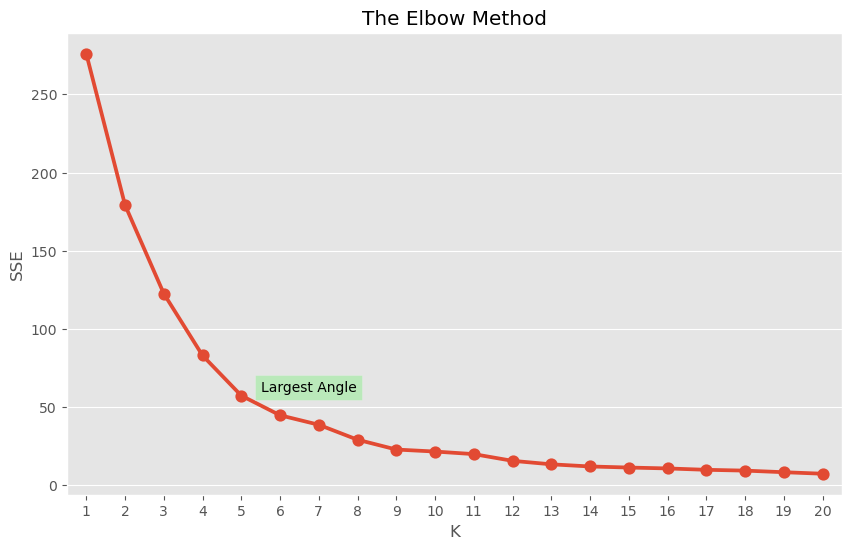

In [42]:
plt.figure(figsize=(10,6))
plt.title('The Elbow Method')

plt.xlabel('K')
plt.ylabel('SSE')
plt.style.use('ggplot')

sns.pointplot(x=list(sse.keys()), y = list(sse.values()))
plt.text(4.5, 60, "Largest Angle", bbox = dict(facecolor = 'lightgreen', alpha = 0.5))
plt.show()

In [43]:
# 5 number of clusters seems good
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(data_normalized)
cluster_labels = kmeans.labels_

data_rfm = data.assign(Cluster = cluster_labels)
data_rfm.head()

,Recency,Frequency,MonetaryValue,Cluster
CUSTOMERNAME,,,,
"AV Stores, Co.",196,51,157807.81,4
Alpha Cognac,65,20,70488.44,2
Amica Models & Co.,265,26,94117.26,2
"Anna's Decorations, Ltd",84,46,153996.13,4
Atelier graphique,188,7,24179.96,1


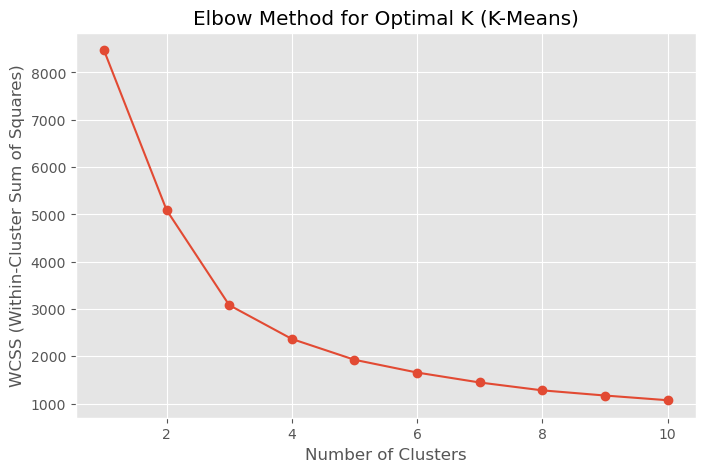

✅ Optimal number of clusters (K-Means): 3


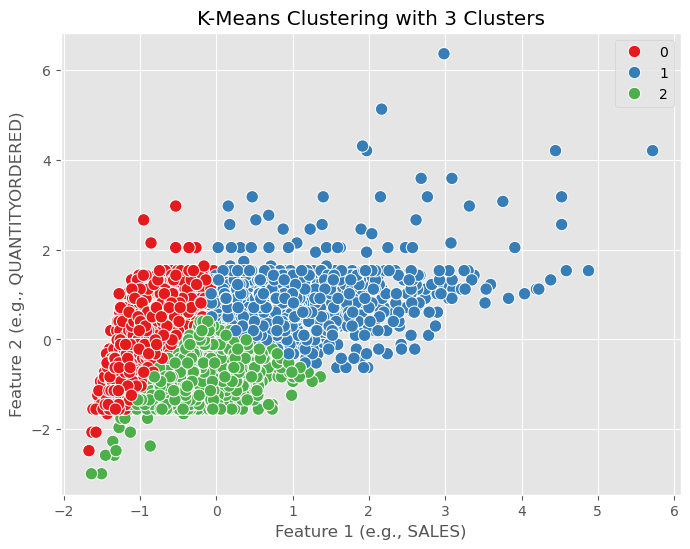

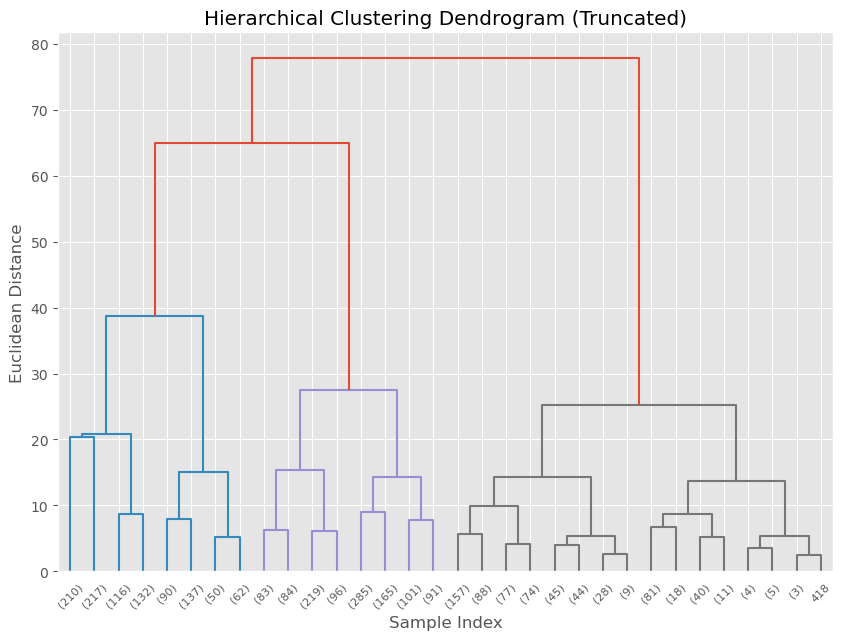

✅ Number of clusters (Hierarchical Clustering): 4


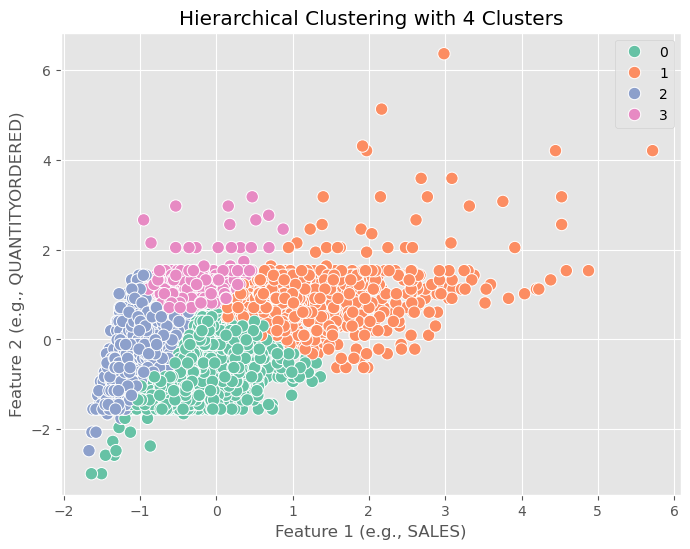


✅ Clustering completed successfully!


In [44]:
# Assignment No-06
# Implement K-Means / Hierarchical Clustering on sales_data_sample.csv dataset
# Determine optimal clusters using the Elbow Method

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import seaborn as sns

# ---------------- Load Dataset ----------------
data = pd.read_csv('./sales_data_sample.csv', encoding='ISO-8859-1')

# ---------------- Select Relevant Features ----------------
# Ensure these columns exist in your dataset
features = data[['SALES', 'QUANTITYORDERED', 'PRICEEACH']]

# ---------------- Standardize Data ----------------
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# ---------------- Elbow Method for K-Means ----------------
wcss = []  # within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K (K-Means)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

# ---------------- Determine Optimal K (Automatically) ----------------
def optimal_k_elbow(wcss):
    x1, y1 = 1, wcss[0]
    x2, y2 = 10, wcss[-1]
    distances = []
    for i in range(10):
        x0 = i + 1
        y0 = wcss[i]
        numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator / denominator)
    return distances.index(max(distances)) + 1

optimal_k = optimal_k_elbow(wcss)
print(f'✅ Optimal number of clusters (K-Means): {optimal_k}')

# ---------------- Apply K-Means ----------------
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(scaled_features)

# Visualize K-Means Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=scaled_features[:, 0], y=scaled_features[:, 1],
                hue=kmeans_labels, palette='Set1', s=80)
plt.title(f'K-Means Clustering with {optimal_k} Clusters')
plt.xlabel('Feature 1 (e.g., SALES)')
plt.ylabel('Feature 2 (e.g., QUANTITYORDERED)')
plt.show()

# ---------------- Hierarchical Clustering ----------------
linked = linkage(scaled_features, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending',
           show_leaf_counts=True, truncate_mode='level', p=4)
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Sample Index')
plt.ylabel('Euclidean Distance')
plt.show()

# Choose number of clusters manually after viewing dendrogram (e.g., 4)
optimal_hc = 4
hc = AgglomerativeClustering(n_clusters=optimal_hc, metric='euclidean', linkage='ward')
hierarchical_labels = hc.fit_predict(scaled_features)

print(f'✅ Number of clusters (Hierarchical Clustering): {optimal_hc}')

# Visualize Hierarchical Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=scaled_features[:, 0], y=scaled_features[:, 1],
                hue=hierarchical_labels, palette='Set2', s=80)
plt.title(f'Hierarchical Clustering with {optimal_hc} Clusters')
plt.xlabel('Feature 1 (e.g., SALES)')
plt.ylabel('Feature 2 (e.g., QUANTITYORDERED)')
plt.show()

print("\n✅ Clustering completed successfully!")
